In [5]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os

import logging

logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

In [6]:
import warnings


def fragment_number(precursor_df, fragment_intensity_df):
    if not set(["frag_start_idx", "frag_stop_idx"]).issubset(precursor_df.columns):
        warnings.warn("frag_start_idx and frag_stop_idx not in dataframe")
        return

    n_fragments = []

    for start, stop in zip(
        precursor_df["frag_start_idx"].values, precursor_df["frag_stop_idx"].values
    ):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df["n_fragments"] = n_fragments


def calc_isotope_dist(precursor_df, max_isotope=6, min_intensity=0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ["i_{}".format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.0

    for i in tqdm(range(len(precursor_df))):
        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row["sequence"], row["mods"])
        )
        dist[dist < 0.001] = 0.0
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [7]:
lib_location = "/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/31min_whisper_d0lib/DIARefLib_Lib4_report-lib.tsv"
output_location = "/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/31min_whisper_d0lib/DIARefLib_d0-d12.hdf"

In [8]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.add_modification_mapping(
    {
        "Oxidation@M": ["M(Oxidation)"],
        "Dimethyl@K": ["K(Dimethyl)"],
        "Dimethyl@R": ["R(Dimethyl)"],
        "Dimethyl@Any N-term": ["(Dimethyl)"],
    }
)
psm = target_lib.import_file(lib_location)

In [9]:
target_lib.precursor_df[
    target_lib.precursor_df["sequence"] == "AAAAAAAAAPAAAATAPTTAATTAATAAQ"
]

,genes,nAA,sequence,mod_sites,precursor_mz,proteins,charge,mobility,mods,rt,frag_start_idx,frag_stop_idx,rt_norm,ccs
95328,SRP14,29,AAAAAAAAAPAAAATAPTTAATTAATAAQ,0,599.81586,SRP14_HUMAN,4,0.968437,Dimethyl@Any N-term,38.169868,1159282,1159310,0.379856,780.231014
95329,SRP14,29,AAAAAAAAAPAAAATAPTTAATTAATAAQ,0,799.41870,SRP14_HUMAN,3,1.151563,Dimethyl@Any N-term,38.028263,1159310,1159338,0.378447,695.827270


In [10]:
flat_mz = target_lib.fragment_mz_df.iloc[1139600:1139628].values.flatten()
flat_intensity = target_lib.fragment_intensity_df.iloc[1139600:1139628].values.flatten()

flat_mz = flat_mz[flat_intensity > 0]
flat_intensity = flat_intensity[flat_intensity > 0]

print(flat_mz)
print(flat_intensity)

[ 546.31335445  433.22929047  326.20743283  440.25036027  569.29295336
  644.39775278  515.35515969  402.27109572 1097.62010114  984.53603716
  492.77165681  887.48327331  773.44034587  644.39775278  698.33554645
  515.35515969  811.41961043  402.27109572  378.15157518  465.18360358
  462.23068745]
[0.07409088 0.08116804 0.01231671 0.28859752 0.21193026 0.01283478
 0.34206697 1.         0.36566922 1.         0.0746287  0.35540047
 0.25897393 0.21401659 0.03653926 0.2058766  0.01852394 0.2842702
 0.492846   0.36142048 0.98214966]


In [11]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

frag_types = get_charged_frag_types(["b", "y", "b_modloss", "y_modloss"], 2)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = "timsTOF"

res = model_mgr.predict_all(
    target_lib.precursor_df,
    predict_items=["ms2"],
    frag_types=frag_types,
)

target_lib._precursor_df = res["precursor_df"]
target_lib._fragment_mz_df = res["fragment_mz_df"]
target_lib._fragment_intensity_df = res["fragment_intensity_df"]

2023-05-17 22:57:01> Using multiprocessing with 8 processes ...
2023-05-17 22:57:01> Predicting ms2 ...


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


In [12]:
target_lib._precursor_df

,genes,nAA,sequence,mod_sites,precursor_mz,proteins,charge,mobility,mods,rt,rt_norm,ccs,frag_stop_idx,nce,instrument,frag_start_idx
0,AARS1,7,ALNEALK,0;7,407.75528,SYAC_HUMAN,2,0.773646,Dimethyl@Any N-term;Dimethyl@K,3.438339,0.034217,315.119139,6,30,timsTOF,0
1,PRKDC,7,DFVQVMR,0,922.48151,PRKDC_HUMAN,1,1.292500,Dimethyl@Any N-term,45.800545,0.455794,262.721544,12,30,timsTOF,6
2,PRKDC,7,DWSNDVR,0,307.14713,PRKDC_HUMAN,3,0.727396,Dimethyl@Any N-term,7.271747,0.072366,443.572301,18,30,timsTOF,12
3,PRKDC,7,DWSNDVR,0,460.21704,PRKDC_HUMAN,2,0.817500,Dimethyl@Any N-term,7.190968,0.071563,332.351102,24,30,timsTOF,18
4,PRKDC,7,DWSNDVR,0,919.42682,PRKDC_HUMAN,1,1.297500,Dimethyl@Any N-term,7.148069,0.071136,263.750782,30,30,timsTOF,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113785,GALK1,18,DGLVSLLTTSEGADEPQR,0,479.74564,GALK1_HUMAN,4,0.795208,Dimethyl@Any N-term,85.945183,0.855303,641.591445,1387316,30,timsTOF,1387299
113786,GAA,18,AHFPLDVQWNDLDYMDSR,0,1125.51780,LYAG_HUMAN,2,1.231042,Dimethyl@Any N-term,89.131897,0.887016,496.088624,1387333,30,timsTOF,1387316
113787,GAA,18,AHFPLDVQWNDLDYMDSR,0,750.68097,LYAG_HUMAN,3,0.928750,Dimethyl@Any N-term,89.165329,0.887349,561.403851,1387350,30,timsTOF,1387333
113788,GAPVD1,18,LPNFGSHVLTPAEMEAFK,0;18,682.02393,GAPD1_HUMAN,3,0.907045,Dimethyl@Any N-term;Dimethyl@K,80.700493,0.803109,548.622875,1387367,30,timsTOF,1387350


In [13]:
target_lib.precursor_df["decoy"] = 0
target_lib._precursor_df["channel"] = 0
target_lib._fragment_mz_df = target_lib._fragment_mz_df[
    ["b_z1", "b_z2", "y_z1", "y_z2"]
]
target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[
    ["b_z1", "b_z2", "y_z1", "y_z2"]
]
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib._precursor_df["elution_group_idx"] = np.arange(len(target_lib._precursor_df))

In [14]:
calc_isotope_dist(target_lib.precursor_df)

100%|██████████| 113790/113790 [00:44<00:00, 2570.95it/s]


In [15]:
from alphabase.constants import modification

modification.add_new_modifications(
    {
        "Dimethyl:d12@Protein N-term": {"composition": "H(-2)2H(8)13C(2)"},
        "Dimethyl:d12@Any N-term": {
            "composition": "H(-2)2H(8)13C(2)",
        },
        "Dimethyl:d12@R": {
            "composition": "H(-2)2H(8)13C(2)",
        },
        "Dimethyl:d12@K": {
            "composition": "H(-2)2H(8)13C(2)",
        },
    }
)

In [16]:
from alphabase.peptide import fragment

channel_lib_list = []
for channel, original_mod, new_mod in [
    (4, "Dimethyl@", "Dimethyl:2H(4)@"),
    (8, "Dimethyl@", "Dimethyl:2H(6)13C(2)@"),
    (12, "Dimethyl@", "Dimethyl:d12@"),
]:
    channel_lib = target_lib.copy()

    channel_lib._precursor_df["mods"] = channel_lib._precursor_df["mods"].str.replace(
        original_mod, new_mod
    )
    channel_lib._precursor_df["channel"] = channel
    fragment.update_precursor_mz(channel_lib._precursor_df)
    channel_lib.calc_fragment_mz_df()
    channel_lib_list += [channel_lib]
    channel_lib.precursor_df.head()

In [17]:
for lib in channel_lib_list:
    target_lib.append(lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z2', 'y_modloss_z1', 'b_modloss_z1', 'b_modloss_z2'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z2', 'y_modloss_z1', 'b_modloss_z1', 'b_modloss_z2'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z2', 'y_modloss_z1', 'b_modloss_z1', 'b_modloss_z2'}.
  warnings.warn(


In [18]:
target_lib.precursor_df.sort_values("elution_group_idx", inplace=True)
target_lib.remove_unused_fragments()

In [19]:
target_lib.precursor_df.columns

Index(['genes', 'nAA', 'sequence', 'mod_sites', 'precursor_mz', 'proteins',
       'charge', 'mobility', 'mods', 'rt', 'rt_norm', 'ccs', 'frag_stop_idx',
       'nce', 'instrument', 'frag_start_idx', 'decoy', 'channel',
       'n_fragments', 'elution_group_idx', 'i_0', 'i_1', 'i_2', 'i_3', 'i_4',
       'i_5'],
      dtype='object')

In [23]:
decoy_lib = SpecLibBase()
decoy_lib._precursor_df = target_lib.precursor_df.copy()
decoy_lib._fragment_mz_df = target_lib.fragment_mz_df.copy()
decoy_lib._fragment_intensity_df = target_lib.fragment_intensity_df.copy()
decoy_lib._precursor_df = decoy_lib.precursor_df[decoy_lib.precursor_df["channel"] == 0]
decoy_lib.remove_unused_fragments()

In [25]:
decoy_lib.decoy = "diann"
decoy_lib.append_decoy_sequence()

In [33]:
decoy_lib._precursor_df = decoy_lib.precursor_df[decoy_lib.precursor_df["decoy"] == 1]
decoy_lib.calc_precursor_mz()

In [34]:
decoy_lib._precursor_df

,genes,nAA,sequence,mod_sites,precursor_mz,proteins,charge,mobility,mods,rt,...,decoy,channel,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5
0,VIM,7,FLNYIEK,0;7,982.560795,VIME_HUMAN,1,1.292500,Dimethyl@Any N-term;Dimethyl@K,15.896462,...,1,0,10,1497,0.576646,0.306345,0.092855,0.020516,0.003638,0.000000
1,GRB2,7,NNQIFVR,0,459.761426,GRB2_HUMAN,2,0.856042,Dimethyl@Any N-term,28.276155,...,1,0,8,4461,0.581761,0.305026,0.090406,0.019456,0.003352,0.000000
2,GRB2,7,NNQIFVR,0,918.515576,GRB2_HUMAN,1,1.296250,Dimethyl@Any N-term,28.418859,...,1,0,10,4460,0.581761,0.305026,0.090406,0.019456,0.003352,0.000000
3,GRB2,7,YLLWVLK,0;7,495.822964,GRB2_HUMAN,2,0.848636,Dimethyl@Any N-term;Dimethyl@K,90.964607,...,1,0,9,4458,0.521054,0.333291,0.113453,0.027123,0.005079,0.000000
4,GRPEL1,7,DENPHVK,0;7,447.737617,GRPE1_HUMAN,2,0.828333,Dimethyl@Any N-term;Dimethyl@K,-26.135765,...,1,0,10,4456,0.609336,0.288573,0.081923,0.017228,0.002939,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96522,VGLL4,30,ALAPTMSLHGSHLYTSLPSLGLEQPLALSK,0;6;30,1068.916084,VGLL4_HUMAN,3,1.235417,Dimethyl@Any N-term;Oxidation@M;Dimethyl@K,88.677544,...,1,0,31,99839,0.153922,0.269492,0.254742,0.170592,0.090030,0.039612
96523,VGLL4,30,ALAPTMSLHGSHLYTSLPSLGLEQPLALSK,0;6;30,801.938882,VGLL4_HUMAN,4,1.121250,Dimethyl@Any N-term;Oxidation@M;Dimethyl@K,88.716599,...,1,0,19,99838,0.153922,0.269492,0.254742,0.170592,0.090030,0.039612
96524,VGLL4,30,ALAPTMSLHGSHLYTSLPSLGLEQPLALSK,0;30,797.940153,VGLL4_HUMAN,4,1.118864,Dimethyl@Any N-term;Dimethyl@K,88.690498,...,1,0,17,99837,0.154295,0.270086,0.254939,0.170353,0.089659,0.039323
96525,PRCC,30,GLALLPPPPQMLAPAFPPPLLLPPPTGDLR,0;11,1047.603000,PRCC_HUMAN,3,1.180000,Dimethyl@Any N-term;Oxidation@M,96.142807,...,1,0,18,99816,0.151132,0.269569,0.256686,0.171919,0.090273,0.039354


In [35]:
frag_types = get_charged_frag_types(["b", "y", "b_modloss", "y_modloss"], 2)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = "timsTOF"

res = model_mgr.predict_all(
    decoy_lib.precursor_df,
    predict_items=["ms2"],
    frag_types=frag_types,
)

decoy_lib._precursor_df = res["precursor_df"]
decoy_lib._fragment_mz_df = res["fragment_mz_df"]
decoy_lib._fragment_intensity_df = res["fragment_intensity_df"]

2023-05-17 23:06:46> Using multiprocessing with 8 processes ...
2023-05-17 23:06:47> Predicting ms2 ...


100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


In [36]:
decoy_lib._precursor_df

,genes,nAA,sequence,mod_sites,precursor_mz,proteins,charge,mobility,mods,rt,...,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5,frag_stop_idx,frag_start_idx
0,VIM,7,FLNYIEK,0;7,982.560795,VIME_HUMAN,1,1.292500,Dimethyl@Any N-term;Dimethyl@K,15.896462,...,10,1497,0.576646,0.306345,0.092855,0.020516,0.003638,0.000000,6,0
1,GRB2,7,NNQIFVR,0,459.761426,GRB2_HUMAN,2,0.856042,Dimethyl@Any N-term,28.276155,...,8,4461,0.581761,0.305026,0.090406,0.019456,0.003352,0.000000,12,6
2,GRB2,7,NNQIFVR,0,918.515576,GRB2_HUMAN,1,1.296250,Dimethyl@Any N-term,28.418859,...,10,4460,0.581761,0.305026,0.090406,0.019456,0.003352,0.000000,18,12
3,GRB2,7,YLLWVLK,0;7,495.822964,GRB2_HUMAN,2,0.848636,Dimethyl@Any N-term;Dimethyl@K,90.964607,...,9,4458,0.521054,0.333291,0.113453,0.027123,0.005079,0.000000,24,18
4,GRPEL1,7,DENPHVK,0;7,447.737617,GRPE1_HUMAN,2,0.828333,Dimethyl@Any N-term;Dimethyl@K,-26.135765,...,10,4456,0.609336,0.288573,0.081923,0.017228,0.002939,0.000000,30,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96522,XRN2,28,MNNNSSPSISPNTSFTSDGSPSPLGGVK,0;28,709.592090,XRN2_HUMAN,4,0.956563,Dimethyl@Any N-term;Dimethyl@K,62.313644,...,21,99528,0.201579,0.297554,0.245379,0.146026,0.069297,0.027643,1233972,1233945
96523,XRN2,28,MNNNSSPSISPNTSFTSDGSPSPLGGVK,0;28,945.787027,XRN2_HUMAN,3,1.027046,Dimethyl@Any N-term;Dimethyl@K,62.247112,...,27,99527,0.201579,0.297554,0.245379,0.146026,0.069297,0.027643,1233999,1233972
96524,WNK1,28,QLIPASSMPQQIGIPTSSLTQVVHSALR,0,747.664121,WNK1_HUMAN,4,1.058750,Dimethyl@Any N-term,81.484138,...,19,99536,0.190224,0.293848,0.249260,0.151251,0.072764,0.029297,1234026,1233999
96525,TPP2,28,GLSADGALGVSISAPGGAIASVPNWTVR,0,884.476565,TPP2_HUMAN,3,1.207727,Dimethyl@Any N-term,92.090027,...,22,99534,0.225910,0.321067,0.243270,0.129574,0.054165,0.018848,1234053,1234026


In [37]:
target_lib.append(decoy_lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z2', 'y_modloss_z1', 'b_modloss_z1', 'b_modloss_z2'}.
  warnings.warn(


In [21]:
target_lib.precursor_df["n_fragments_allowed"] = target_lib.precursor_df["n_fragments"]

In [38]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [39]:
target_lib.precursor_df = target_lib.precursor_df[
    target_lib.precursor_df["n_fragments"] >= 3
].copy()
target_lib.remove_unused_fragments()

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

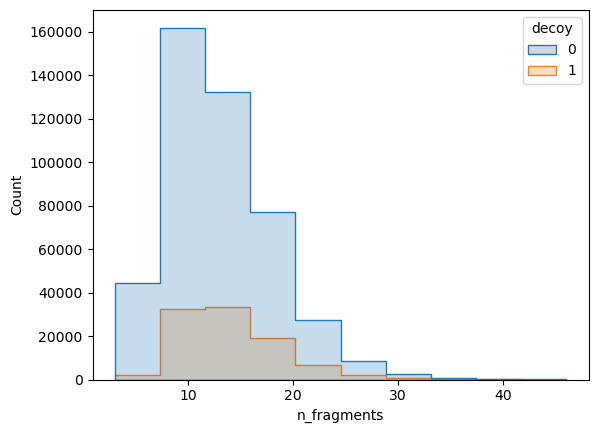

In [40]:
import seaborn as sns

sns.histplot(
    target_lib.precursor_df, x="n_fragments", hue="decoy", element="step", bins=10
)

In [41]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(
    zip(
        target_lib.precursor_df["frag_start_idx"].values,
        target_lib.precursor_df["frag_stop_idx"].values,
        target_lib.precursor_df["n_fragments_allowed"].values,
    )
):
    intensies = target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[
        intensies <= flat_intensities[k_allowed]
    ] = 0

KeyError: 'n_fragments_allowed'

In [116]:
target_lib.precursor_df.drop(columns=["n_fragments"], inplace=True)

In [117]:
target_lib.precursor_df.columns

Index(['mobility', 'charge', 'mods', 'sequence', 'nAA', 'proteins', 'genes',
       'rt', 'mod_sites', 'precursor_mz', 'frag_start_idx', 'frag_stop_idx',
       'rt_norm', 'ccs', 'decoy', 'channel', 'elution_group_idx', 'i_0', 'i_1',
       'i_2', 'i_3', 'i_4', 'i_5'],
      dtype='object')

In [37]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib.fragment_cardinality_df = fragment.calc_fragment_cardinality(
    target_lib.precursor_df, target_lib._fragment_mz_df
)

In [42]:
target_lib.precursor_df["rt_norm"] = (
    target_lib.precursor_df["rt"] - target_lib.precursor_df["rt"].min()
)
target_lib.precursor_df["rt_norm"] = (
    target_lib.precursor_df["rt_norm"] / target_lib.precursor_df["rt_norm"].max()
)

In [45]:
target_lib.precursor_df["rt"] = target_lib.precursor_df["rt_norm"]

In [55]:
target_lib.save_hdf(output_location)

In [49]:
allowed_egs = target_lib.precursor_df[target_lib.precursor_df["decoy"] == 1][
    "elution_group_idx"
].values

In [53]:
target_lib._precursor_df = target_lib.precursor_df[
    target_lib.precursor_df["elution_group_idx"].isin(allowed_egs)
].copy()
target_lib.remove_unused_fragments()

In [54]:
target_lib._precursor_df

,genes,nAA,sequence,mod_sites,precursor_mz,proteins,charge,mobility,mods,rt,...,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5,mod_seq_hash,mod_seq_charge_hash
0,TRAM1,7,FINFQLR,0,977.629287,TRAM1_HUMAN,1,1.295000,Dimethyl:d12@Any N-term,0.764255,...,10,1127,0.560641,0.316010,0.097843,0.021691,0.003815,0.000000,18062612592567817213,18062612592567817214
1,PSMA3,7,EDASNLR,0,832.415922,PSA3_HUMAN,1,1.296477,Dimethyl@Any N-term,0.112439,...,10,122,0.621491,0.280694,0.078599,0.016417,0.002800,0.000000,12277776280074278559,12277776280074278560
2,PRSS3P2,7,RLGVYSK,0;7,439.776545,TRY6_HUMAN,2,0.820521,Dimethyl@Any N-term;Dimethyl@K,0.072980,...,10,121,0.600283,0.296999,0.083090,0.016882,0.002745,0.000000,10122416790602396509,10122416790602396511
3,PRPS2,7,EQIAELK,0;7,886.524410,PRPS2_HUMAN,1,1.297500,Dimethyl@Any N-term;Dimethyl@K,0.443405,...,10,120,0.579298,0.303892,0.092464,0.020635,0.003711,0.000000,5045608984513781769,5045608984513781770
4,PRORP,7,ALFDFLK,0;7,455.275847,MRPP3_HUMAN,2,0.835938,Dimethyl@Any N-term;Dimethyl@K,0.805422,...,8,106,0.575640,0.309164,0.092089,0.019740,0.003368,0.000000,8163656170500570792,8163656170500570794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482630,ACTB;ACTG1,30,TTGIVMDSGDGVTHTVPIYEGYALPHAILR,0,1071.220100,ACTB_HUMAN;ACTG_HUMAN,3,1.281042,Dimethyl@Any N-term,0.897818,...,25,99904,0.154840,0.269853,0.254411,0.170125,0.089729,0.039481,13255808968325690649,13255808968325690652
482631,C1QBP,30,GVDNTFADELVELSTALEHQEYITFLEDLK,0;30,874.690920,C1QBP_HUMAN,4,1.090000,Dimethyl@Any N-term;Dimethyl@K,0.986558,...,28,99903,0.137609,0.259346,0.258073,0.179322,0.097310,0.043792,13078257450726770516,13078257450726770520
482632,CAPN2,30,ADYQAVDDEIEANLEEFDISEDDIDDGFRR,0,883.893190,CAN2_HUMAN,4,1.098437,Dimethyl@Any N-term,0.950823,...,20,99902,0.146189,0.264506,0.255996,0.174547,0.093564,0.041812,4349062121450959234,4349062121450959238
482633,ATP5F1B,30,GFQQILAGEYDHLPEQAFYMVGPIEEAVAK,0;30,852.431150,ATPB_HUMAN,4,1.110000,Dimethyl@Any N-term;Dimethyl@K,0.966105,...,23,99920,0.132931,0.251552,0.254988,0.182215,0.102293,0.047776,8121938871935625283,8121938871935625287
